# Purposed Method Evaluation for Breast cancer detection

*    on [BreaKHis](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis) dataseet 

## import libraries and connect to drive

In [ ]:
!pip install catboost

import numpy as np
import tensorflow as tf
import time
import glob
import os
import random
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML, display, clear_output
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score, auc, roc_curve, precision_recall_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras.applications as k_apps
print(tf.version)

from google.colab import drive
drive.mount('/content/drive')


size = (460,700)
working_dir = 'drive/MyDrive/article-97'
InceptionResNetV2 = {
    'model': k_apps.inception_resnet_v2.InceptionResNetV2, 'preprocessor': k_apps.inception_resnet_v2.preprocess_input, 'activation': 'conv_7b_ac',
}


     |████████████████████████████████| 76.1 MB 1.6 MB/s 
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>
Mounted at /content/drive


## Reading images and extracting features 

In [ ]:
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)


X = {"breast_40":[], "breast_100":[], "breast_200":[], "breast_400":[]}
y = {"breast_40":[], "breast_100":[], "breast_200":[], "breast_400":[]}


def get_features(mag):
  pre_extracted_file = f'{working_dir}/extracted_features/InceptionResNetV2-{mag}.txt'
  if os.path.isfile(pre_extracted_file):
    print(f'[ {mag} pre-extracted features file was FOUND] : {pre_extracted_file}')
    with open(pre_extracted_file , 'r') as f:
      l = f.readline()
      while l != '':
          X[mag].append([float(x) for x in l.split()])
          l = f.readline()
      X[mag] = np.array(X[mag])
      y[mag] = X[mag][:, -3]
      X[mag] = X[mag][:, :-3]

  else:
    print(f'[ {mag} pre-extracted features file NOT FOUND]')

    model = InceptionResNetV2['model'](input_shape=size+(3,), weights=None, pooling='max')
    preprocess_input = InceptionResNetV2['preprocessor']
    print(f'[start reading images and extracting features] \nfeture extractor: {featureExt}, {model} \npreprocessor    : {preprocess_input}\n')

    paths = glob.glob(f'{working_dir}/tf_files/{mag}/*/*')

    out = display(HTML("<progress style='width: 50%'/>"), display_id=True)
    n = len(paths)
    for i in range(n):
        img = image.load_img(str(paths[i]), target_size=size)
        img = image.img_to_array(img)
        img = preprocess_input(img) 
        img = np.expand_dims(img, axis=0)
        features = model.predict(img)

        X[mag].append(features[0])
        y[mag].append(1 if paths[i].split('/')[-1].split('_')[1] == 'M' else 0)

        out.update(HTML(f"[{i+1}/{n} images are processed] <br><progress value={i+1} max={n} , style='width: 60%'/></progress>  [{(i+1)/n*100:.2f}]%"))

    # convert to np.array
    X[mag] = np.array(X)
    y[mag] = np.array(y[mag])

  print(f"==> available features on {mag} :   X : {X[mag].shape}   y : {y[mag].shape}\n")

get_features("breast_40")
get_features("breast_100")
get_features("breast_200")
get_features("breast_400")


[ breast_40 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionResNetV2-breast_40.txt
==> available features on breast_40 :   X : (1995, 1000)   y : (1995,)

[ breast_100 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionResNetV2-breast_100.txt
==> available features on breast_100 :   X : (2081, 1000)   y : (2081,)

[ breast_200 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionResNetV2-breast_200.txt
==> available features on breast_200 :   X : (2013, 1000)   y : (2013,)

[ breast_400 pre-extracted features file was FOUND] : drive/MyDrive/article-97/extracted_features/InceptionResNetV2-breast_400.txt
==> available features on breast_400 :   X : (1820, 1000)   y : (1820,)



## Classification

In [ ]:
def eval(X, y, rs):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = rs)
  c_probas = []
  clfs = [XGBClassifier(learning_rate = 0.34, silent = True),
          LGBMClassifier(learning_rate = 0.11, silent = True),
          CatBoostClassifier(l2_leaf_reg=3, border_count=128, iterations=1000, depth=7, logging_level='Silent')]

  for c in clfs:
    c.fit(X_train, y_train)
    c_probas.append(c.predict_proba(X_test))

  all_probas = ((c_probas[0] + c_probas[1] + c_probas[2]) / 3)[:, 1]
  y_pred = all_probas > 0.5

  fpr, tpr, _ = roc_curve(y_test, all_probas)
  pre, rec, _ = precision_recall_curve(y_test, all_probas)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  return [accuracy_score(y_test, y_pred),
          balanced_accuracy_score(y_test, y_pred),
          f1_score(y_test, y_pred),
          auc(fpr, tpr), #ROC AUC
          (tn, fp, fn, tp),
          (fpr, tpr),
          auc(rec, pre), #PRC AUC
          (pre, rec)
          ]

e__40 = eval(X['breast_40'],  y['breast_40'])
e_100 = eval(X['breast_100'], y['breast_100'])
e_200 = eval(X['breast_200'], y['breast_200'])
e_400 = eval(X['breast_400'], y['breast_400'])

In [ ]:

print(f'''
• features extrated by InceptionResNetV2
• classification by ensemble of XGBClassifier, LGBMClassifier and CatBoostClassifier

                            40×        100×        200×        400×
   - accuracy         :   {e__40[0]*100:.2f}       {e_100[0]*100:.2f}       {e_200[0]*100:.2f}       {e_400[0]*100:.2f}
   - balanced accuracy:   {e__40[1]*100:.2f}       {e_100[1]*100:.2f}       {e_200[1]*100:.2f}       {e_400[1]*100:.2f}
   - F1_score         :   {e__40[2]*100:.2f}       {e_100[2]*100:.2f}       {e_200[2]*100:.2f}       {e_400[2]*100:.2f}
   - ROC AUC          :   {e__40[3]:.3f}       {e_100[3]:.3f}       {e_200[3]:.3f}       {e_400[3]:.3f}
   - PRC AUC          :   {e__40[6]:.3f}       {e_100[6]:.3f}       {e_200[6]:.3f}       {e_400[6]:.3f}

   - Confusion matrix :   40×: | {e__40[4][0]} {e__40[4][1]} |    100×: | {e_100[4][0]} {e_100[4][1]} |    200×: | {e_200[4][0]} {e_200[4][1]} |    400×: | {e_400[4][0]} {e_400[4][1]} |
                               | {e__40[4][2]}  {e__40[4][3]} |          | {e_100[4][2]} {e_100[4][3]} |          | {e_200[4][2]}  {e_200[4][3]} |          | {e_400[4][2]}  {e_400[4][3]} |
''')



• features extrated by InceptionResNetV2
• classification by ensemble of XGBClassifier, LGBMClassifier and CatBoostClassifier

                            40×        100×        200×        400×
   - accuracy         :   96.83       95.84       97.02       96.15
   - balanced accuracy:   95.64       94.90       95.89       95.15
   - F1_score         :   97.76       97.03       97.87       97.11
   - ROC AUC          :   0.992       0.992       0.993       0.993
   - PRC AUC          :   0.997       0.997       0.997       0.996

   - Confusion matrix :   40×: | 165 13 |    100×: | 174 14 |    200×: | 172 13 |    400×: | 172 15 |
                               | 6  415 |          | 12 425 |          | 5  414 |          | 6  353 |



In [ ]:
matplotlib.rcdefaults()
plt.rcParams.update({'xtick.labelsize':10, 
                     'ytick.labelsize':10,
                     'legend.fontsize':10,
                     'axes.labelsize' :18})

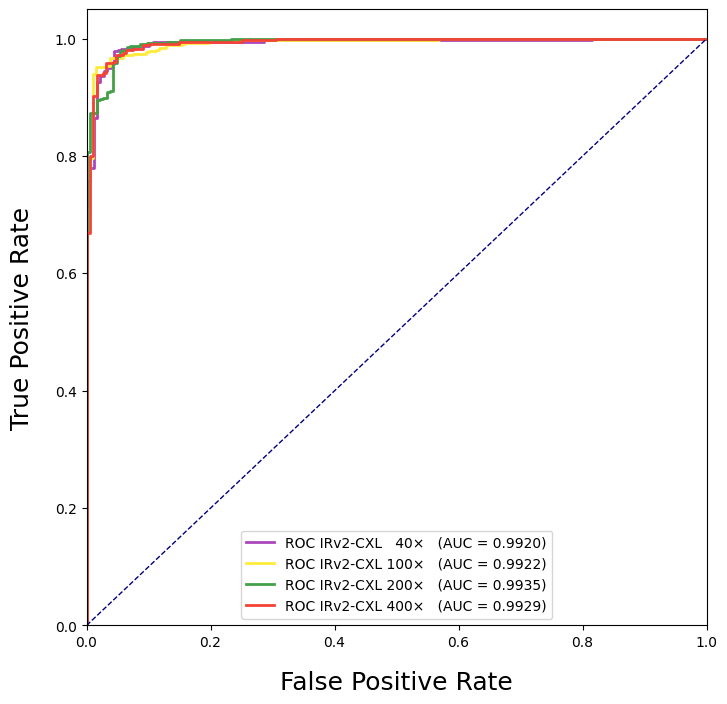

In [ ]:
plt.figure(figsize = (8, 8))

plt.plot(e__40[5][0], e__40[5][1], color="#AB47BC", lw=2, label= f"ROC IRv2-CXL   40×   (AUC = {e__40[3]:.4f})")
plt.plot(e_100[5][0], e_100[5][1], color="#FFEB3B", lw=2, label= f"ROC IRv2-CXL 100×   (AUC = {e_100[3]:.4f})")
plt.plot(e_200[5][0], e_200[5][1], color="#43A047", lw=2, label= f"ROC IRv2-CXL 200×   (AUC = {e_200[3]:.4f})")
plt.plot(e_400[5][0], e_400[5][1], color="#F44336", lw=2, label= f"ROC IRv2-CXL 400×   (AUC = {e_400[3]:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate", labelpad = 15)
plt.ylabel("True Positive Rate", labelpad = 15)
plt.legend(loc="lower center")

plt.show()

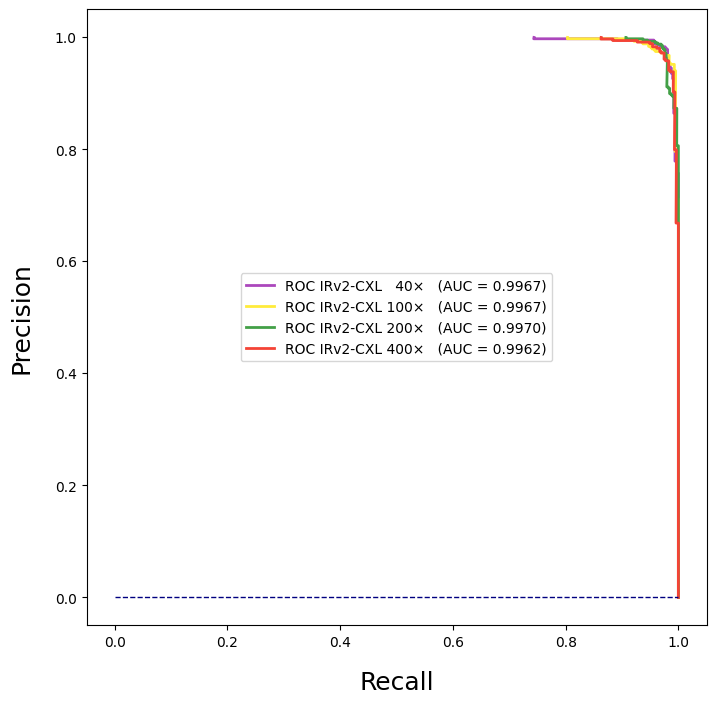

In [ ]:
plt.figure(figsize = (8, 8))

plt.plot(e__40[7][0], e__40[7][1], color="#AB47BC", lw=2, label= f"ROC IRv2-CXL   40×   (AUC = {e__40[6]:.4f})")
plt.plot(e_100[7][0], e_100[7][1], color="#FFEB3B", lw=2, label= f"ROC IRv2-CXL 100×   (AUC = {e_100[6]:.4f})")
plt.plot(e_200[7][0], e_200[7][1], color="#43A047", lw=2, label= f"ROC IRv2-CXL 200×   (AUC = {e_200[6]:.4f})")
plt.plot(e_400[7][0], e_400[7][1], color="#F44336", lw=2, label= f"ROC IRv2-CXL 400×   (AUC = {e_400[6]:.4f})")
plt.plot([0, 1], [0,0], color="navy", lw=1, linestyle="--")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel("Recall", labelpad = 15)
plt.ylabel("Precision", labelpad = 15)
plt.legend(loc="center")

plt.show()